In [5]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy


In [6]:

# Load SpaCy and stopwords
nlp = spacy.load('en_core_web_sm')
stop_words = set(stopwords.words('english'))

# Function to clean text
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = ' '.join([word for word in text.split() if word.lower() not in stop_words])  # Remove stopwords
    return text


In [7]:




# Function to lemmatize text
def lemmatize_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

# Load datasets
print("Loading datasets...")
fake_data = pd.read_csv('Fake.csv')
real_data = pd.read_csv('True.csv')


Loading datasets...


In [10]:
import re
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word.lower() not in stop_words])
    return text


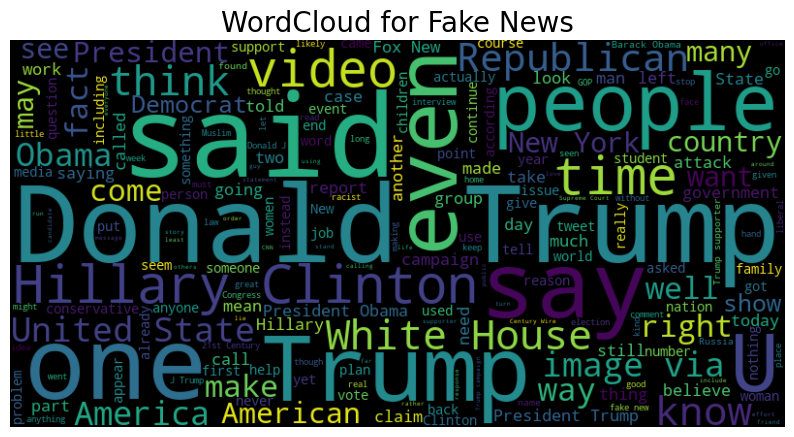

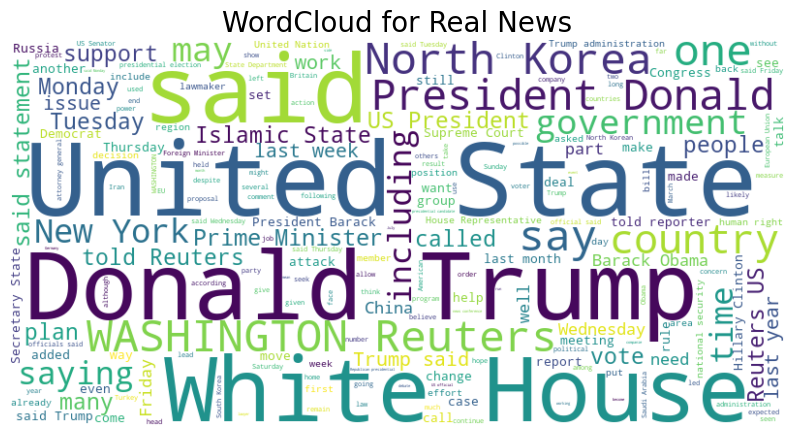

In [11]:

# WordCloud for Fake News
fake_content = ' '.join(df[df['label'] == 1]['content'])
wordcloud_fake = WordCloud(width=800, height=400, background_color='black').generate(fake_content)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.title('WordCloud for Fake News', fontsize=20)
plt.axis('off')
plt.show()

# WordCloud for Real News
real_content = ' '.join(df[df['label'] == 0]['content'])
wordcloud_real = WordCloud(width=800, height=400, background_color='white').generate(real_content)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.title('WordCloud for Real News', fontsize=20)
plt.axis('off')
plt.show()


In [12]:

# Balance dataset
fake_news = df[df['label'] == 1]
real_news = df[df['label'] == 0]
min_class_count = min(len(fake_news), len(real_news))
balanced_df = pd.concat([
    fake_news.sample(min_class_count, random_state=42),
    real_news.sample(min_class_count, random_state=42)
]).sample(frac=1, random_state=42)


In [13]:

# Split dataset
X = balanced_df['content']
y = balanced_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7, max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


In [14]:

# Logistic Regression Model
log_model = LogisticRegression(C=1.0, penalty='l2', solver='lbfgs', random_state=42)
log_model.fit(X_train_tfidf, y_train)
y_pred_log = log_model.predict(X_test_tfidf)


In [15]:

# Naive Bayes Model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)


In [16]:

# Random Forest Model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_test_tfidf)


Model: Logistic Regression
Accuracy: 0.99
ROC-AUC: 1.00

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4205
           1       0.99      0.99      0.99      4362

    accuracy                           0.99      8567
   macro avg       0.99      0.99      0.99      8567
weighted avg       0.99      0.99      0.99      8567



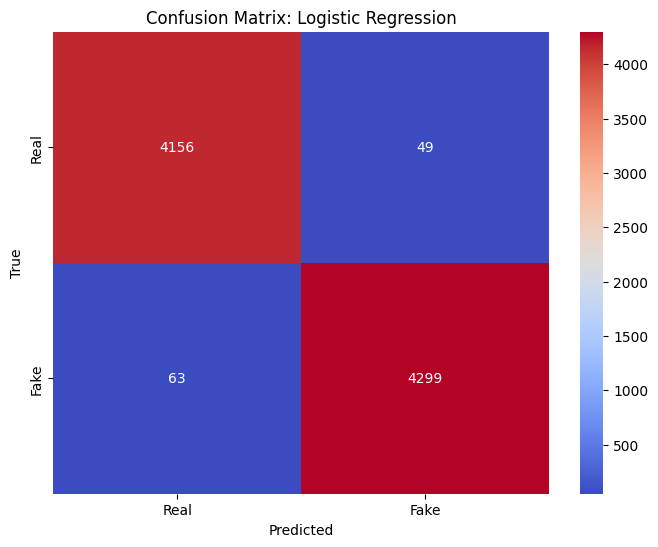

Model: Naive Bayes
Accuracy: 0.93
ROC-AUC: 1.00

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      4205
           1       0.93      0.93      0.93      4362

    accuracy                           0.93      8567
   macro avg       0.93      0.93      0.93      8567
weighted avg       0.93      0.93      0.93      8567



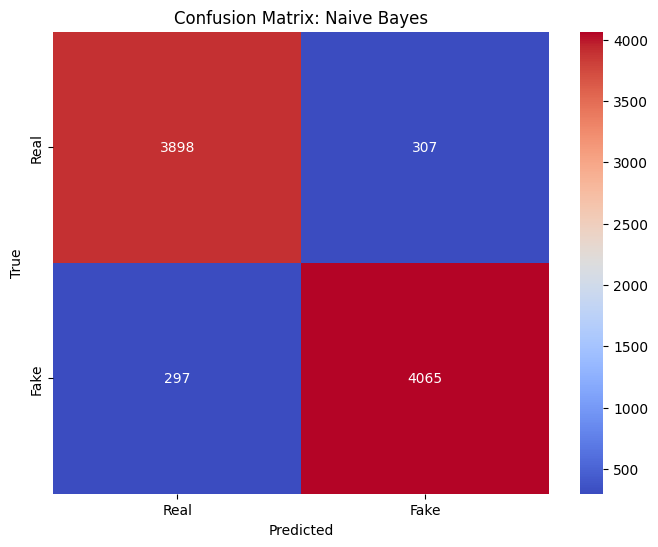

Model: Random Forest
Accuracy: 1.00
ROC-AUC: 1.00

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4205
           1       1.00      1.00      1.00      4362

    accuracy                           1.00      8567
   macro avg       1.00      1.00      1.00      8567
weighted avg       1.00      1.00      1.00      8567



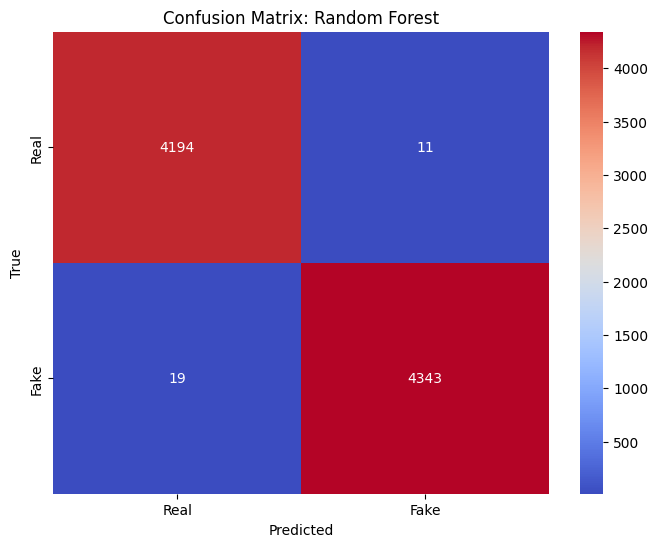

In [17]:

# Evaluation
def evaluate_model(model_name, y_test, y_pred):
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"ROC-AUC: {roc_auc_score(y_test, log_model.predict_proba(X_test_tfidf)[:, 1]):.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.show()

# Evaluate each model
evaluate_model("Logistic Regression", y_test, y_pred_log)
evaluate_model("Naive Bayes", y_test, y_pred_nb)
evaluate_model("Random Forest", y_test, y_pred_rf)


In [18]:

# Hyperparameter Tuning (Logistic Regression)
param_grid = {'C': [0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train_tfidf, y_train)
print("Best Parameters for Logistic Regression:", grid.best_params_)


Best Parameters for Logistic Regression: {'C': 10}


In [19]:

# Test with Custom Input
new_text = ["Breaking news: Stock markets crash due to global recession fears."]
new_text_tfidf = tfidf_vectorizer.transform(new_text)
prediction = log_model.predict(new_text_tfidf)
confidence = log_model.predict_proba(new_text_tfidf)[0]

print(f"Prediction: {'Fake News' if prediction[0] == 1 else 'Real News'}")
print(f"Confidence: Real News ({confidence[0]:.2f}), Fake News ({confidence[1]:.2f})")


Prediction: Fake News
Confidence: Real News (0.12), Fake News (0.88)


In [26]:
# from joblib import dump, load

# # Save the Logistic Regression model
# dump(log_model, "logistic_regression_model.joblib")

# print("Model saved successfully!")


Model saved successfully!


In [27]:
# from joblib import dump, load

# # Save the Naive Bayes model
# dump(nb_model, "naive_bayes_model.joblib")

# print("Naive Bayes model saved successfully!")


Naive Bayes model saved successfully!


In [28]:
# from joblib import dump, load

# # Save the Random Forest model
# dump(rf_model, "random_forest_model.joblib")

# print("Random Forest model saved successfully!")


Random Forest model saved successfully!
